In [1]:
!pip install pandas numpy scikit-learn xgboost imbalanced-learn kagglehub matplotlib seaborn joblib --quiet

In [5]:
import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier


In [3]:
import kagglehub

path = kagglehub.dataset_download("arunavakrchakraborty/australia-weather-data")
print("Downloaded path:", path)
if path.endswith(".zip"):
    extract_dir = os.path.splitext(path)[0] + "_extracted"
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(path, 'r') as z:
        z.extractall(extract_dir)
    # find csv
    files = [f for f in os.listdir(extract_dir) if f.lower().endswith(".csv")]
    if not files:
        raise FileNotFoundError("CSV not found inside extracted archive.")
    csv_path = os.path.join(extract_dir, files[0])
else:
    csv_path = path
print("Using CSV:", csv_path)


100%|█████████████████████████████████████████████████████████████████████████████| 3.86M/3.86M [00:03<00:00, 1.02MB/s]

Extracting files...


Downloaded path: C:\Users\offic\.cache\kagglehub\datasets\arunavakrchakraborty\australia-weather-data\versions\1
Using CSV: C:\Users\offic\.cache\kagglehub\datasets\arunavakrchakraborty\australia-weather-data\versions\1


In [6]:
for root, dirs, files in os.walk(path):
    for file in files:
        print("Found file:", file)


Found file: Weather Test Data.csv
Found file: Weather Training Data.csv


In [7]:
src = os.path.join(path, "Weather Training Data.csv")    # Change name if different
dst = r"C:\Users\Public\Weather Training Data.csv"

shutil.copy(src, dst)

print("Copied file to:", dst)


Copied file to: C:\Users\Public\Weather Training Data.csv


In [9]:
df = pd.read_csv(r"C:\Users\Public\Weather Training Data.csv")
df.head()


,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


In [10]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99516 entries, 0 to 99515
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row ID         99516 non-null  object 
 1   Location       99516 non-null  object 
 2   MinTemp        99073 non-null  float64
 3   MaxTemp        99286 non-null  float64
 4   Rainfall       98537 non-null  float64
 5   Evaporation    56985 non-null  float64
 6   Sunshine       52199 non-null  float64
 7   WindGustDir    92995 non-null  object 
 8   WindGustSpeed  93036 non-null  float64
 9   WindDir9am     92510 non-null  object 
 10  WindDir3pm     96868 non-null  object 
 11  WindSpeed9am   98581 non-null  float64
 12  WindSpeed3pm   97681 non-null  float64
 13  Humidity9am    98283 non-null  float64
 14  Humidity3pm    97010 non-null  float64
 15  Pressure9am    89768 non-null  float64
 16  Pressure3pm    89780 non-null  float64
 17  Cloud9am       61944 non-null  float64
 18  Cloud3

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
count,99073.000000,99286.000000,98537.000000,56985.00000,52199.000000,93036.000000,98581.000000,97681.000000,98283.000000,97010.000000,89768.000000,89780.000000,61944.000000,59514.000000,98902.000000,97612.000000,99516.000000
mean,12.176266,23.218513,2.353024,5.46132,7.615090,39.976966,14.004849,18.650464,68.866376,51.433296,1017.684638,1015.286204,4.447985,4.519122,16.970041,21.681340,0.224677
std,6.390882,7.115072,8.487866,4.16249,3.783008,13.581524,8.902323,8.801827,19.074951,20.777616,7.110166,7.045189,2.886580,2.716618,6.488961,6.931681,0.417372
min,-8.500000,-4.100000,0.000000,0.00000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.200000,0.000000,0.000000,-7.000000,-5.100000,0.000000
25%,7.600000,17.900000,0.000000,2.60000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.80000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.700000,1015.300000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.40000,10.600000,48.000000,19.000000,24.000000,83.000000,65.000000,1022.400000,1020.000000,7.000000,7.000000,21.500000,26.400000,0.000000
max,33.900000,48.100000,371.000000,86.20000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [11]:
df = df.dropna(subset=["RainTomorrow"])  
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

print("Missing values handled.")


Missing values handled.


In [12]:
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("Label encoding complete.")


Label encoding complete.


In [13]:
X = df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (79612, 22)
Test size: (19904, 22)


In [15]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)
print("Model training complete.")


Model training complete.


In [16]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.857516077170418

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     15402
           1       0.76      0.54      0.63      4502

    accuracy                           0.86     19904
   macro avg       0.82      0.75      0.77     19904
weighted avg       0.85      0.86      0.85     19904



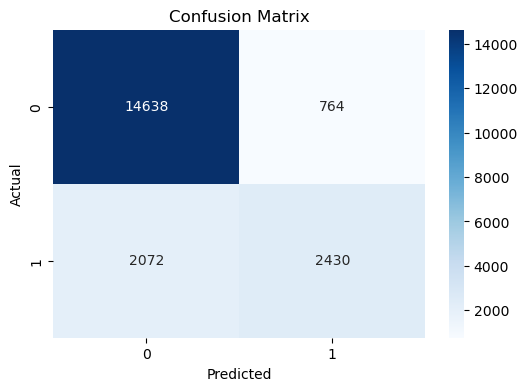

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

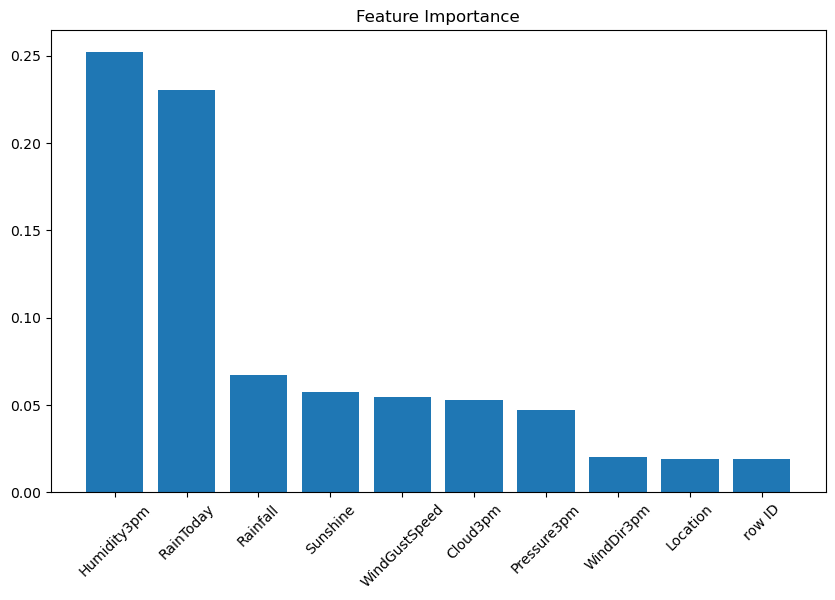

In [18]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), X.columns[indices][:10], rotation=45)
plt.show()

In [19]:
sample = X_test.iloc[0:1]
print("Sample Input:")
print(sample)

print("\nPrediction:", model.predict(sample)[0])


Sample Input:
       row ID  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
81773   81812        32     10.4     26.4       0.0         10.0      11.6   

       WindGustDir  WindGustSpeed  WindDir9am  ...  WindSpeed3pm  Humidity9am  \
81773           13           37.0           9  ...          22.0         51.0   

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
81773         42.0       1017.9       1014.0       5.0       2.0     21.0   

       Temp3pm  RainToday  
81773     25.0          0  

[1 rows x 22 columns]

Prediction: 0


In [23]:

sample = X_test.sample(1, random_state=42)
print("Input data:\n", sample)
prediction = model.predict(sample)[0]

print("\nPrediction:", prediction)

if prediction == 1:
    print("➡ It will rain tomorrow")
else:
    print("➡ It will not rain tomorrow")


Input data:
        row ID  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
64866   63030        39     22.7     30.7       2.2          3.8       5.3   

       WindGustDir  WindGustSpeed  WindDir9am  ...  WindSpeed3pm  Humidity9am  \
64866            3           31.0           3  ...          15.0         71.0   

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
64866         66.0       1011.4       1006.8       7.0       7.0     27.4   

       Temp3pm  RainToday  
64866     29.2          1  

[1 rows x 22 columns]

Prediction: 0
➡ It will not rain tomorrow
